# Image Classification

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

import tarfile
import pickle
import random
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

## DatasetFetcher

In [2]:
class DatasetFetcher:
    
    def fetch_cifar10_dataset(self):
        """
        Fetch CIFAR-10 data.
        """
        
        print('\nFetching CIFAR-10 dataset...\n')
        
        floyd_cifar10_loc = '/cifar/cifar-10-python.tar.gz'
        cifar10_gz_path = 'cifar-10-python.tar.gz'
        cifar10_dataset_name = 'CIFAR-10 Dataset'
        cifar10_dataset_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
        
        if isfile(floyd_cifar10_loc):
            tar_gz_path = floyd_cifar10_loc
        else:
            tar_gz_path = cifar10_gz_path
            
        if not isfile(tar_gz_path):
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc=cifar10_dataset_name)\
                as pbar:
                    urlretrieve(cifar10_dataset_url, tar_gz_path, pbar.hook)

        if not isdir(cifar10_dataset_folder_path):
            with tarfile.open(tar_gz_path) as tar:
                tar.extractall()
                tar.close()
                
        print('\nFetched CIFAR-10 dataset\n')

        
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num    

## DataBatchLoader

In [3]:
class DataBatchLoader:
    
    def load_cifar10_batch(self, batch_id):
        """
        Load a batch of the dataset.
        : batch_id: Batch ID
        """
        
        batch_name = cifar10_dataset_folder_path + '/data_batch_' + str(batch_id)
        
        with open(batch_name, mode='rb') as file:
            batch = pickle.load(file, encoding='latin1')

        features = batch['data']\
            .reshape((len(batch['data']), 3, 32, 32))\
            .transpose(0, 2, 3, 1)
        labels = batch['labels']

        return features, labels
    
    
    def load_preprocessed_training_batch(self, batch_id, batch_size):
        """
        Load the preprocessed training data and return them in batches of batch_size.
        : batch_id: Batch ID
        : batch_size: Batch size
        """
        filename = 'preprocess_batch_' + str(batch_id) + '.p'
        features, labels = pickle.load(open(filename, mode='rb'))
        return self.batch_features_labels(features, labels, batch_size)
    
    
    def batch_features_labels(self, features, labels, batch_size):
        """
        Split features and labels into batches.
        """
        for start in range(0, len(features), batch_size):
            end = min(start + batch_size, len(features))
            yield features[start:end], labels[start:end]

## DataExplorer

In [4]:
class DataExplorer:

    def __init__(self, batchLoader=DataBatchLoader()):
        self.batchLoader = batchLoader;
    
    
    def explore_data(self, batch_id, sample_id):
        """
        Display batch stats and sample image.
        : batch_id: Batch ID
        : sample_id: Sample ID
        """
        
        batch_ids = list(range(1, 6))

        if batch_id not in batch_ids:
            print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
            return None

        features, labels = self.batchLoader.load_cifar10_batch(batch_id)

        if not (0 <= sample_id < len(features)):
            print('{} samples in batch {}.  {} is out of range.'.format(
                len(features), batch_id, sample_id))
            return None

        print('\nStats of batch {}:'.format(batch_id))
        print('Samples: {}'.format(len(features)))
        print('Label Counts: {}'.format(
            dict(zip(*np.unique(labels, return_counts=True)))))
        print('First 20 Labels: {}'.format(labels[:20]))

        sample_image = features[sample_id]
        sample_label = labels[sample_id]
        label_names = self.load_label_names()

        print('\nExample of Image {}:'.format(sample_id))
        print('Image - Min Value: {} Max Value: {}'.format(
            sample_image.min(), sample_image.max()))
        print('Image - Shape: {}'.format(sample_image.shape))
        print('Label - Label Id: {} Name: {}'.format(
            sample_label, label_names[sample_label]))
        
        plt.axis('off')
        plt.imshow(sample_image)
        
        
    def load_label_names(self):
        """
        Load the label names from file.
        """
        return ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']

## DataPreprocessor

In [5]:
class DataPreprocessor:
    
    def __init__(self, batchLoader=DataBatchLoader()):
        self.batchLoader = batchLoader;

        
    def preprocess_and_save_data(self):
        """
        Preprocess training and validation data.
        """
        
        print('\nPreprocessing and saving data ...')
        
        n_batches = 5
        valid_features = []
        valid_labels = []
        
        for batch_i in range(1, n_batches+1):
            features, labels = self.batchLoader.load_cifar10_batch(batch_i)
            validation_count = int(len(features) * 0.1)

            # Preprocess and save a batch of training data
            self.preprocess_and_save(self.normalize,
                                     self.one_hot_encode,
                                     features[:-validation_count],
                                     labels[:-validation_count],
                                     'preprocess_batch_'+str(batch_i)+'.p')
            
            print('Preprocessed and saved a batch of training data')

            # Use a portion of training batch for validation
            valid_features.extend(features[-validation_count:])
            valid_labels.extend(labels[-validation_count:])

        # Preprocess and save all validation data
        self.preprocess_and_save(self.normalize,
                                 self.one_hot_encode,
                                 np.array(valid_features),
                                 np.array(valid_labels),
                                 'preprocess_validation.p')
        
        print('Preprocessed and saved validation data')
        
        test_batch_name = cifar10_dataset_folder_path + '/test_batch'

        with open(test_batch_name, mode='rb') as file:
            batch = pickle.load(file, encoding='latin1')

        # Load the test data
        test_features = batch['data']\
            .reshape((len(batch['data']), 3, 32, 32))\
            .transpose(0, 2, 3, 1)
        test_labels = batch['labels']

        # Preprocess and Save all test data
        self.preprocess_and_save(self.normalize,
                                 self.one_hot_encode,
                                 np.array(test_features),
                                 np.array(test_labels),
                                 'preprocess_test.p')
        
        print('Preprocessed and saved test data')
        
        print('Preprocessed and saved all data\n')
        
        
    def preprocess_and_save(self, normalize, one_hot_encode, features, labels, filename):
        """
        Preprocess data and save it to file.
        : normalize: Function to normalize data
        : one_hot_encode: Function to one-hot-encode data
        : features: Features
        : labels: Labels
        : filename: Name of file to which save data
        """
        features = normalize(features)
        labels = one_hot_encode(labels)
        pickle.dump((features, labels), open(filename, 'wb'))
        

    def normalize(self, x):
        """
        Normalize a list of sample image data in the range of 0 to 1.
        : x: List of image data.  The image shape is (32, 32, 3)
        : return: Numpy array of normalized data
        """
        npx = np.array(x)
        x_normed = npx / npx.max(axis=0)
        return x_normed # return x/255
    
    
    def one_hot_encode(self, x):
        """
        One-hot-encode a list of sample labels. 
        Return a one-hot encoded vector for each label.
        : x: List of sample labels
        : return: Numpy array of one-hot encoded labels
        """
        npx = np.array(x).reshape(-1, 1)
        enc = OneHotEncoder(n_values=10)
        enc.fit(npx)
        encoded = enc.transform(npx).toarray()
        return encoded # return np.eye(10)[x]

# Loading, Preprocessing, Saving, and Exploring Data

In [6]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [7]:
datasetFetcher = DatasetFetcher()

datasetFetcher.fetch_cifar10_dataset()

CIFAR-10 Dataset: 0.00B [00:00, ?B/s]


Fetching CIFAR-10 dataset...



CIFAR-10 Dataset: 171MB [00:29, 5.80MB/s]                              



Fetched CIFAR-10 dataset




Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


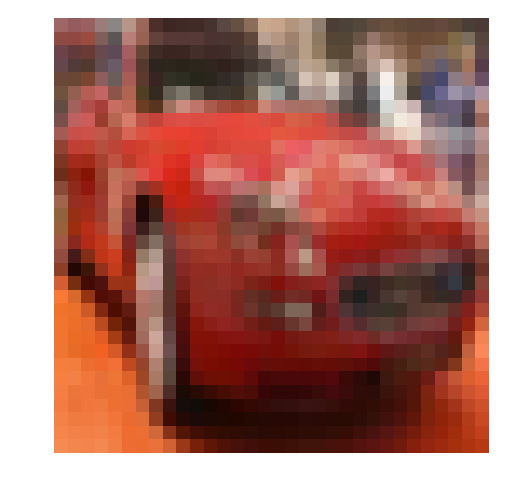

In [8]:
dataBatchLoader = DataBatchLoader()

dataExplorer = DataExplorer(dataBatchLoader)

dataExplorer.explore_data(1, 5)


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 10:
Image - Min Value: 4 Max Value: 231
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


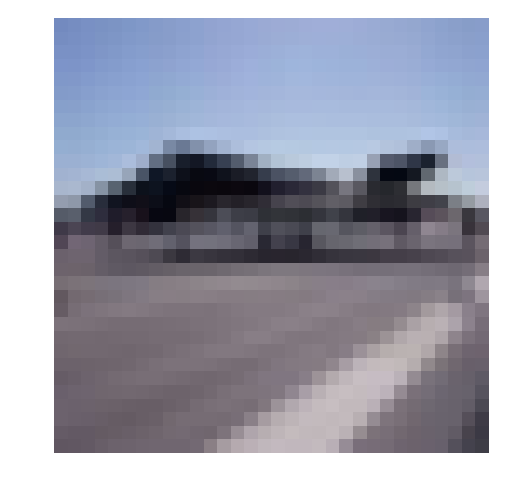

In [9]:
dataExplorer.explore_data(2, 10)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 15:
Image - Min Value: 59 Max Value: 210
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


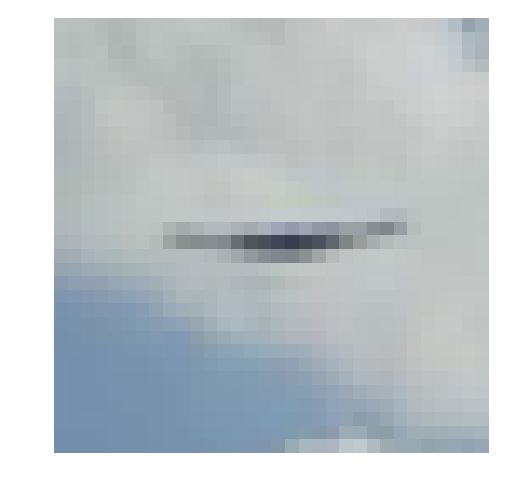

In [10]:
dataExplorer.explore_data(3, 15)


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 20:
Image - Min Value: 18 Max Value: 223
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


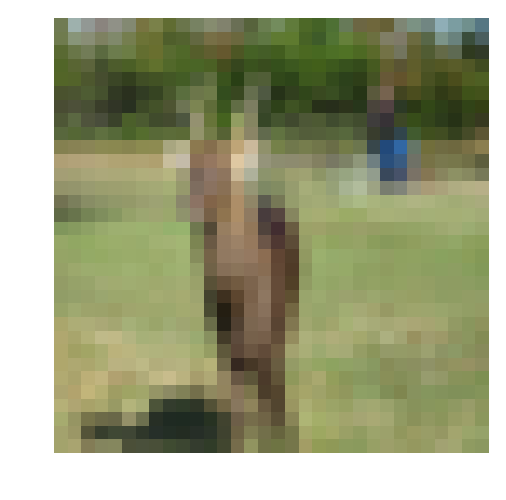

In [11]:
dataExplorer.explore_data(4, 20)


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 25:
Image - Min Value: 0 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


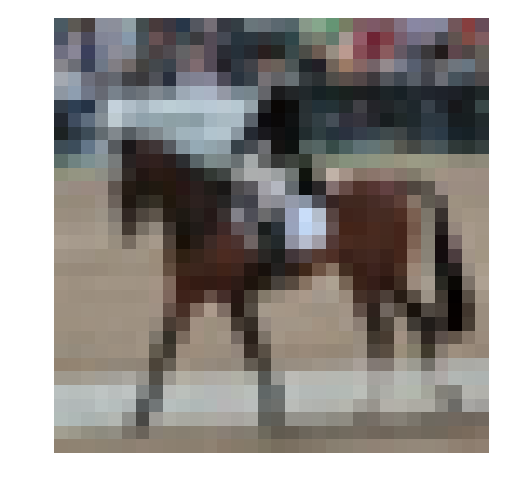

In [12]:
dataExplorer.explore_data(5, 25)

In [13]:
dataPreprocessor = DataPreprocessor(dataBatchLoader)

dataPreprocessor.preprocess_and_save_data()


Preprocessing and saving data ...
Preprocessed and saved a batch of training data
Preprocessed and saved a batch of training data
Preprocessed and saved a batch of training data
Preprocessed and saved a batch of training data
Preprocessed and saved a batch of training data
Preprocessed and saved validation data
Preprocessed and saved test data
Preprocessed and saved all data



# Checkpoint

In [14]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## PlaceholderCreator

In [15]:
class PlaceholderCreator:

    def create_image_placeholder(self, image_shape):
        """
        Return a Tensor for a batch of image input.
        : image_shape: Shape of the images
        : return: Tensor for image input
        """
        return tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name="x")

    
    def create_label_placeholder(self, n_classes):
        """
        Return a Tensor for a batch of label input.
        : n_classes: Number of classes
        : return: Tensor for label input
        """
        return tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name="y")
    
    
    def create_keep_prob_placeholder(self):
        """
        Return a Tensor for keep probability.
        : return: Tensor for keep probability
        """
        return tf.placeholder(dtype=tf.float32, name="keep_prob")

## ConvMaxPoolLayerBuilder

In [16]:
class ConvMaxPoolLayerBuilder:
    
    def build_layers(self, 
                     x_tensor, 
                     conv_num_outputs, 
                     conv_ksize, 
                     conv_strides,
                     pool_ksize,
                     pool_strides):
        """
        Apply convolution then max pooling to x_tensor.
        : x_tensor: TensorFlow Tensor
        : conv_num_outputs: Number of outputs for the convolutional layer
        : conv_ksize: Kernal size 2-D Tuple for the convolutional layer
        : conv_strides: Stride 2-D Tuple for convolution
        : pool_ksize: Kernal size 2-D Tuple for pool
        : pool_strides: Stride 2-D Tuple for pool
        : return: A tensor that represents convolution and max pooling of x_tensor
        """
        
        conv_layer_out = self.build_conv2d_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides)
        maxpool_layer_out = self.build_maxpool2d_layer(conv_layer_out, pool_ksize, pool_strides)
        
        self.print_input_output(x_tensor, conv_layer_out, conv_layer_out, maxpool_layer_out)

        return maxpool_layer_out
    

    def build_conv2d_layer(self, x, conv_num_outputs, conv_ksize, conv_strides):
        """
        Build a convolution layer.
        """
        weights, bias, stride_shape = self.get_conv_weights_and_bias(x,
                                                                     conv_num_outputs,
                                                                     conv_ksize,
                                                                     conv_strides)
        return self.conv2d(x, weights, bias, stride_shape)
    

    def build_maxpool2d_layer(self, x, pool_ksize, pool_strides):
        """
        Build a max-pooling layer.
        """
        ksize_shape, stride_shape = self.get_pool_ksize_stride_shapes(pool_ksize, pool_strides)
        
        return self.maxpool2d(x, ksize_shape, stride_shape)
    
    
    def conv2d(self, x, weights, bias, stride_shape):
        x = tf.nn.conv2d(x, weights, stride_shape, padding='SAME')
        x = tf.nn.bias_add(x, bias)
        return tf.nn.relu(x)
    

    def maxpool2d(self, x, ksize_shape, stride_shape):
        return tf.nn.max_pool(x, ksize=ksize_shape, strides=stride_shape, padding='SAME')
    
    
    def get_conv_weights_and_bias(self, x, conv_num_outputs, conv_ksize, conv_strides):
        input_depth = x.get_shape().as_list()[-1]
        weight_shape = [conv_ksize[0], conv_ksize[1], input_depth, conv_num_outputs]
        
        weights = tf.Variable(tf.truncated_normal(weight_shape, mean=0.0, stddev=0.05))
        bias = tf.Variable(tf.zeros(conv_num_outputs))
        
        stride_shape = [1, conv_strides[0], conv_strides[1], 1]
        
        return weights, bias, stride_shape
    

    def get_pool_ksize_stride_shapes(self, pool_ksize, pool_stride):
        ksize_shape = [1, pool_ksize[0], pool_ksize[1], 1]
        stride_shape = [1, pool_strides[0], pool_strides[1], 1]
        return ksize_shape, stride_shape
    

    def print_input_output(self, conv_input, conv_output, pool_input, pool_output):
        print('{} = {}'.format('conv_layer_input', conv_input))
        print('{} = {}'.format('conv_layer_output', conv_output))
        print('{} = {}'.format('pool_layer_input', pool_input))
        print('{} = {}\n'.format('pool_layer_output', pool_output))

## FlattenLayerBuilder

In [17]:
class FlattenLayerBuilder:
    
    def build_layer(self, x_tensor):
        """
        Flatten x_tensor to (Batch Size, Flattened Image Size).
        : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions
        : return: A tensor of size (Batch Size, Flattened Image Size)
        """
        
        flat_out = tf.contrib.layers.flatten(x_tensor)
        
        self.print_input_output(x_tensor, flat_out)
        
        return flat_out

    
    def print_input_output(self, flat_input, flat_output):
        print('{} = {}'.format('flat_layer_input', flat_input))
        print('{} = {}\n'.format('flat_layer_output', flat_output))

## FullyConnectedLayerBuilder

In [18]:
class FullyConnectedLayerBuilder:
    
    def build_layer(self, x_tensor, num_outputs):
        """
        Apply a fully connected layer to x_tensor using weight and bias.
        : x_tensor: A 2-D tensor where the first dimension is batch size
        : num_outputs: The number of output that the new tensor should be
        : return: A 2-D tensor where the second dimension is num_outputs
        """
        
        weights, bias = self.get_weights_and_bias(x_tensor, num_outputs)
        
        fc_layer_out = self.fc(x_tensor, weights, bias)
        
        self.print_input_output(x_tensor, fc_layer_out)

        return fc_layer_out
    

    def fc(self, x, weights, bias):
        x = tf.reshape(x, [-1, weights.get_shape().as_list()[0]])
        x = tf.matmul(x, weights)
        x = tf.nn.bias_add(x, bias)
        return tf.nn.relu(x)
    
    
    def get_weights_and_bias(self, x, num_outputs):
        input_shape = x.get_shape()
        input_size = int(input_shape[1])
        
        weights = tf.Variable(tf.truncated_normal([input_size, num_outputs], 
                                                   mean=0.0, 
                                                   stddev=0.05))
        bias = tf.Variable(tf.zeros(num_outputs))
        
        return weights, bias
    

    def print_input_output(self, fc_input, fc_output):
        print('{} = {}'.format('fc_layer_input', fc_input))
        print('{} = {}\n'.format('fc_layer_output', fc_output))

## OutputLayerBuilder

In [19]:
class OutputLayerBuilder:
    
    def build_layer(self, x_tensor, num_outputs):
        """
        Apply a output layer to x_tensor using weight and bias.
        : x_tensor: A 2-D tensor where the first dimension is batch size
        : num_outputs: The number of output that the new tensor should be
        : return: A 2-D tensor where the second dimension is num_outputs
        """

        weights, bias = self.get_weights_and_bias(x_tensor, num_outputs)

        out = tf.add(tf.matmul(x_tensor, weights), bias)

        self.print_input_output(x_tensor, out)

        return out
    

    def get_weights_and_bias(self, x, num_outputs):
        input_shape = x.get_shape()
        input_size = int(input_shape[1])
        
        weights = tf.Variable(tf.truncated_normal([input_size, num_outputs], 
                                                   mean=0.0, 
                                                   stddev=0.05))
        bias = tf.Variable(tf.zeros(num_outputs))
        
        return weights, bias
    
    
    def print_input_output(self, output_layer_input, output_layer_output):
        print('{} = {}'.format('output_layer_input', output_layer_input))
        print('{} = {}\n'.format('output_layer_output', output_layer_output))

## ConvolutionalModel

In [20]:
class ConvolutionalModel:
    
    def __init__(self, x, y, keep_prob):
        self.x = x
        self.y = y
        self.keep_prob = keep_prob
        
    
    def build_network(self, 
                      conv_ksize, 
                      conv_strides,
                      pool_ksize, 
                      pool_strides,
                      conv_num_outputs,
                      fc_num_outputs,
                      out_num_outputs):
        """
        Create a convolutional neural network.
        : conv_ksize: Kernal size 2-D Tuple for the convolutional layer
        : conv_strides: Stride 2-D Tuple for convolution
        : pool_ksize: Kernal size 2-D Tuple for pool
        : pool_strides: Stride 2-D Tuple for pool
        : conv_num_outputs: Numbers of outputs for the convolutional layers
        : fc_num_outputs: Numbers of outputs for the fully-connected layers
        : out_num_outputs: Number of outputs for the output layer
        : return: Tensor that represents logits
        """
        
        ########## Convolution-MaxPooling Layers ##########
    
        convMaxLayerBuilder = ConvMaxPoolLayerBuilder()
        
        # Convolutional/MaxPooling Layer 1
        self.mark_layer('CONVOLUTIONAL LAYER 1')
        conv1 = convMaxLayerBuilder.build_layers(self.x,
                                                 conv_num_outputs[0], 
                                                 conv_ksize, conv_strides,
                                                 pool_ksize, pool_strides)
        
        # Convolutional/MaxPooling Layer 2
        self.mark_layer('CONVOLUTIONAL LAYER 2')
        conv2 = convMaxLayerBuilder.build_layers(conv1, 
                                                 conv_num_outputs[1], 
                                                 conv_ksize, conv_strides,
                                                 pool_ksize, pool_strides)
        
        # Convolutional/MaxPooling Layer 3
        self.mark_layer('CONVOLUTIONAL LAYER 3')
        conv3 = convMaxLayerBuilder.build_layers(conv2, 
                                                 conv_num_outputs[2], 
                                                 conv_ksize, conv_strides,
                                                 pool_ksize, pool_strides)
        
        ########## Flatten Layer ##########
        
        flatLayerBuilder = FlattenLayerBuilder()
        
        # Flatten Layer
        self.mark_layer('FLATTEN LAYER')
        flat = flatLayerBuilder.build_layer(conv3)
        
        ########## Fully-Connected Layers ##########
        
        fcLayerBuilder = FullyConnectedLayerBuilder()
        
        # Fully-Connected Layer 1
        self.mark_layer('FULLY-CONNECTED LAYER 1')
        fc1 = fcLayerBuilder.build_layer(flat, fc_num_outputs[0])
        fc1 = tf.nn.dropout(fc1, self.keep_prob)
        
        # Fully-Connected Layer 2
        self.mark_layer('FULLY-CONNECTED LAYER 2')
        fc2 = fcLayerBuilder.build_layer(fc1, fc_num_outputs[1])
        fc2 = tf.nn.dropout(fc2, self.keep_prob)
        
        # Fully-Connected Layer 3
        self.mark_layer('FULLY-CONNECTED LAYER 3')
        fc3 = fcLayerBuilder.build_layer(fc2, fc_num_outputs[2])
        fc3 = tf.nn.dropout(fc3, self.keep_prob)
        
        ########## Output Layer ##########
        
        outputLayerBuilder = OutputLayerBuilder()
        
        # Output Layer
        self.mark_layer('OUTPUT LAYER')
        out = outputLayerBuilder.build_layer(fc3, out_num_outputs)

        print('-----------------------------------------------------------------------------')
        
        return out
    

    def mark_layer(self, layer_name):
        print('-----------------------------------------------------------------------------')
        print(layer_name)
        print('')

## ModelBuilder

In [21]:
class ModelBuilder:
    
    def build_model(self, 
                    input_shape, 
                    n_classes,
                    conv_ksize, 
                    conv_strides,
                    pool_ksize, 
                    pool_strides,
                    conv_num_outputs,
                    fc_num_outputs,
                    out_num_outputs):
        """
        Build a convolutional neural network model.
        : input_shape: Shape of the input images
        : n_classes: Number of classes
        : conv_ksize: Kernal size 2-D Tuple for the convolutional layer
        : conv_strides: Stride 2-D Tuple for convolution
        : pool_ksize: Kernal size 2-D Tuple for pool
        : pool_strides: Stride 2-D Tuple for pool
        : conv_num_outputs: Numbers of outputs for the convolutional layers
        : fc_num_outputs: Numbers of outputs for the fully-connected layers
        : out_num_outputs: Number of outputs for the output layer
        """
        
        print('\nBuilding the convolutional neural network model ...\n')
        
        # Remove previous weights, bias, inputs, etc..
        tf.reset_default_graph()
        
        # Create placeholders
        placeholderCreator = PlaceholderCreator()
        x = placeholderCreator.create_image_placeholder(input_shape)
        y = placeholderCreator.create_label_placeholder(n_classes)
        keep_prob = placeholderCreator.create_keep_prob_placeholder()
        
        # Build model network
        model = ConvolutionalModel(x, y, keep_prob)
        
        logits = model.build_network(conv_ksize, 
                                     conv_strides,
                                     pool_ksize, 
                                     pool_strides,
                                     conv_num_outputs,
                                     fc_num_outputs,
                                     out_num_outputs)

        # Name logits Tensor, so that is can be loaded from disk after training
        model.logits = tf.identity(logits, name='logits')
        
        # Add optimizer and cost function
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, 
                                                                labels=model.y)
        model.cost = tf.reduce_mean(cross_entropy)
        model.optimizer = tf.train.AdamOptimizer().minimize(model.cost)

        # Add accuracy function
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        model.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        
        print('\nModel building complete\n')
        
        return model

## NetworkTrainer

In [22]:
class NetworkTrainer:
    
    def train_network(self, session, model, feature_batch, label_batch, keep_prob):
        """
        Optimize the session on a batch of images and labels
        : session: Current TensorFlow session
        : model: Model to train
        : feature_batch: Batch of Numpy image data
        : label_batch: Batch of Numpy label data
        : keep_probability: Keep probability
        """
        session.run(model.optimizer,
                    feed_dict={
                        model.x: feature_batch,
                        model.y: label_batch,
                        model.keep_prob: keep_prob
                    })

## StatPrinter

In [23]:
class StatPrinter:

    def print_stats(self, session, model, feature_batch, label_batch):
        """
        Print information about loss and validation accuracy.
        : session: Current TensorFlow session
        : model: Model with which to compute loss and accuracy
        : feature_batch: Batch of Numpy image data
        : label_batch: Batch of Numpy label data
        """

        loss = session.run(model.cost, 
                           feed_dict={model.x: feature_batch,
                                      model.y: label_batch,
                                      model.keep_prob: 1.})

        valid_acc = session.run(model.accuracy, 
                                feed_dict={model.x: valid_features,
                                           model.y: valid_labels,
                                           model.keep_prob: 1.})
        
        print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## ModelTrainer

In [24]:
class ModelTrainer:
    
    def __init__(self, 
                 batchLoader=DataBatchLoader(),
                 networkTrainer=NetworkTrainer(),
                 statPrinter=StatPrinter()):
        
        self.batchLoader = batchLoader
        self.networkTrainer = networkTrainer
        self.statPrinter = statPrinter
    
    
    def train_model_on_single_batch(self, model, epochs, batch_size, keep_prob):
        """
        Train the model on a single FICAR-10 data batch.
        : model: Model to train
        : epochs: Number of epochs to train for
        : batch_size: Batch size
        : keep_prob: Keep probability
        """
        
        print('\nTraining the model on a single batch ...\n')
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(epochs):
                batch_i = 1
                
                train_batches = \
                    self.batchLoader.load_preprocessed_training_batch(batch_i, batch_size)
                
                for batch_features, batch_labels in train_batches:
                    self.networkTrainer.train_network(sess,
                                                      model,
                                                      batch_features,
                                                      batch_labels,
                                                      keep_prob)
                    
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch+1, batch_i), end='')
                
                self.statPrinter.print_stats(sess, model, batch_features, batch_labels)
                
        print('\nSingle-batch training complete\n')
        
        
    def fully_train_model(self, model, epochs, batch_size, keep_prob, save_model_path):
        """
        Fully train the model on the FICAR-10 dataset.
        : model: Model to train
        : epochs: Number of epochs to train for
        : batch_size: Batch size
        : keep_prob: Keep probability
        : save_model_path: Location to save file
        """
        
        print('\nFully training the model ...\n')
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(epochs):
                n_batches = 5
                
                for batch_i in range(1, n_batches+1):
                    train_batches = \
                        self.batchLoader.load_preprocessed_training_batch(batch_i, batch_size)
                        
                    for batch_features, batch_labels in train_batches:
                        self.networkTrainer.train_network(sess,
                                                          model,
                                                          batch_features,
                                                          batch_labels,
                                                          keep_prob)
                        
                    print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch+1, batch_i), end='')
                    
                    self.statPrinter.print_stats(sess, model, batch_features, batch_labels)
                    
            # Save trained model
            saver = tf.train.Saver()
            saver.save(sess, save_model_path)
            
        print('\nFull training complete\n')

# Building and Training Model

In [25]:
input_shape = (32, 32, 3)
n_classes = 10

conv_ksize = [3,3]
conv_strides = [1,1]
pool_ksize = [2,2]
pool_strides = [2,2]
        
conv_num_outputs = [32, 64, 128]
fc_num_outputs = [128, 64, 32]
out_num_outputs = 10

epochs = 100
batch_size = 512
keep_probability = 0.75

save_model_path = './image_classification'

In [26]:
modelBuilder = ModelBuilder()

model = modelBuilder.build_model(input_shape, 
                                 n_classes,
                                 conv_ksize, 
                                 conv_strides,
                                 pool_ksize, 
                                 pool_strides,
                                 conv_num_outputs,
                                 fc_num_outputs,
                                 out_num_outputs)


Building the convolutional neural network model ...

-----------------------------------------------------------------------------
CONVOLUTIONAL LAYER 1

conv_layer_input = Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)
conv_layer_output = Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
pool_layer_input = Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
pool_layer_output = Tensor("MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)

-----------------------------------------------------------------------------
CONVOLUTIONAL LAYER 2

conv_layer_input = Tensor("MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
conv_layer_output = Tensor("Relu_1:0", shape=(?, 16, 16, 64), dtype=float32)
pool_layer_input = Tensor("Relu_1:0", shape=(?, 16, 16, 64), dtype=float32)
pool_layer_output = Tensor("MaxPool_1:0", shape=(?, 8, 8, 64), dtype=float32)

-----------------------------------------------------------------------------
CONVOLUTIONAL LAYER 3

conv_layer_input = Tensor("MaxPool_1

In [27]:
networkTrainer = NetworkTrainer()
statPrinter = StatPrinter()

modelTrainer = ModelTrainer(dataBatchLoader, networkTrainer, statPrinter)

modelTrainer.train_model_on_single_batch(model, epochs, batch_size, keep_probability)


Training the model on a single batch ...

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2756 Validation Accuracy: 0.099800
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1895 Validation Accuracy: 0.158600
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.1145 Validation Accuracy: 0.243000
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.0463 Validation Accuracy: 0.257600
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.0186 Validation Accuracy: 0.250200
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.9725 Validation Accuracy: 0.268800
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.8975 Validation Accuracy: 0.301800
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.8500 Validation Accuracy: 0.321600
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.8063 Validation Accuracy: 0.344600
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.7796 Validation Accuracy: 0.353400
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.7301 Validation Accuracy: 0.358600
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.7109 Validation Accuracy: 0.367400
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.6863

In [28]:
modelTrainer.fully_train_model(model, epochs, batch_size, keep_probability, save_model_path)


Fully training the model ...

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2282 Validation Accuracy: 0.151000
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.1191 Validation Accuracy: 0.190400
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.0307 Validation Accuracy: 0.242200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.9140 Validation Accuracy: 0.248400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.8964 Validation Accuracy: 0.277200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9164 Validation Accuracy: 0.313000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.8212 Validation Accuracy: 0.333000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.6772 Validation Accuracy: 0.337600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.6414 Validation Accuracy: 0.368000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.7030 Validation Accuracy: 0.367400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8029 Validation Accuracy: 0.348600
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6907 Validation Accuracy: 0.381600
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.5244 Validation 

Epoch 22, CIFAR-10 Batch 4:  Loss:     0.4744 Validation Accuracy: 0.701800
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.5402 Validation Accuracy: 0.701800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.5811 Validation Accuracy: 0.666000
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.5965 Validation Accuracy: 0.683200
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.4846 Validation Accuracy: 0.706000
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.4428 Validation Accuracy: 0.708600
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.4861 Validation Accuracy: 0.708200
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.5410 Validation Accuracy: 0.682800
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.5288 Validation Accuracy: 0.710600
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.4369 Validation Accuracy: 0.718400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.4305 Validation Accuracy: 0.703400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.4626 Validation Accuracy: 0.715200
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.4730 Validation Accuracy: 0.700400
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.2246 Validation Accuracy: 0.713400
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.2078 Validation Accuracy: 0.724200
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.1960 Validation Accuracy: 0.718400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.1922 Validation Accuracy: 0.734400
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.2214 Validation Accuracy: 0.723600
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.2273 Validation Accuracy: 0.720200
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.2221 Validation Accuracy: 0.723000
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.2042 Validation Accuracy: 0.719200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.1711 Validation Accuracy: 0.725600
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.1954 Validation Accuracy: 0.733400
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.1358 Validation Accuracy: 0.735000
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.1989 Validation Accuracy: 0.727600
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.1760 Validation Accuracy: 0.720200
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0722 Validation Accuracy: 0.733800
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.0803 Validation Accuracy: 0.729400
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.0640 Validation Accuracy: 0.741600
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0606 Validation Accuracy: 0.730000
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0779 Validation Accuracy: 0.739000
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0604 Validation Accuracy: 0.744000
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.0775 Validation Accuracy: 0.737200
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0701 Validation Accuracy: 0.731400
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0791 Validation Accuracy: 0.722000
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0660 Validation Accuracy: 0.741800
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0597 Validation Accuracy: 0.737800
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.0787 Validation Accuracy: 0.733000
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.0646 Validation Accuracy: 0.732600
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0173 Validation Accuracy: 0.732000
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0331 Validation Accuracy: 0.734200
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0222 Validation Accuracy: 0.737400
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0266 Validation Accuracy: 0.731400
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0211 Validation Accuracy: 0.739600
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0211 Validation Accuracy: 0.730600
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0331 Validation Accuracy: 0.732400
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0213 Validation Accuracy: 0.737400
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0285 Validation Accuracy: 0.725400
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0175 Validation Accuracy: 0.738200
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0166 Validation Accuracy: 0.729400
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0279 Validation Accuracy: 0.726800
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0253 Validation Accuracy: 0.739400
Epoch 90, CI

# Checkpoint

## PredictionDisplayer

In [29]:
class PredictionDisplayer:
    
    def __init__(self, 
                 batchLoader=DataBatchLoader(), 
                 dataExplorer=DataExplorer()):
        
        self.batchLoader = batchLoader
        self.dataExplorer = dataExplorer
        
    
    def display_image_predictions(self, features, labels, predictions, n_classes):
        """
        Display image predictions.
        : features:
        : labels:
        : predictions:
        : n_classes: Number of classes
        """
        
        label_names = self.dataExplorer.load_label_names()
        labelBinarizer = LabelBinarizer()
        labelBinarizer.fit(range(n_classes))
        label_ids = labelBinarizer.inverse_transform(np.array(labels))

        fig, axies = plt.subplots(nrows=4, ncols=2)
        fig.tight_layout()
        fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

        n_predictions = 3
        margin = 0.05
        ind = np.arange(n_predictions)
        width = (1. - 2. * margin) / n_predictions

        for image_i, (feature, label_id, pred_indicies, pred_values) \
                in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
            
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]

            axies[image_i][0].imshow(feature)
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

## ModelTester

In [30]:
class ModelTester:
    
    def __init__(self, 
                 batchLoader=DataBatchLoader(),
                 predDisplayer=PredictionDisplayer()):
        
        self.batchLoader = batchLoader
        self.predDisplayer = predDisplayer
        
    
    def test_model(self, save_model_path, n_samples, n_classes, top_n_predidctions):
        """
        Test the saved model against the test dataset.
        : save_model_path: Location where model is saved
        : n_samples: Number of samples
        : n_classes: Number of classes
        : top_n_predictions: Cutoff for top K predictions
        """
        
        print('\nTesting the model ...\n')
        
        try:
            if batch_size:
                pass
        except NameError:
            batch_size = 64
        
        test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
        loaded_graph = tf.Graph()
        
        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph(save_model_path + '.meta')
            loader.restore(sess, save_model_path)
            
            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('x:0')
            loaded_y = loaded_graph.get_tensor_by_name('y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            
            # Get accuracy in batches for memory limitations
            test_batch_acc_total = 0
            test_batch_count = 0
            
            test_batches = self.batchLoader.batch_features_labels(test_features,
                                                                  test_labels,
                                                                  batch_size)
            
            for test_feature_batch, test_label_batch in test_batches:
                test_batch_acc_total += sess.run(loaded_acc,
                                                 feed_dict={loaded_x: test_feature_batch,
                                                            loaded_y: test_label_batch,
                                                            loaded_keep_prob: 1.0})
                test_batch_count += 1

            print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))
            
            # Display predictions on random samples
            random_test_features, random_test_labels = \
                tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
                
            random_test_predictions = sess.run(
                tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
                feed_dict={loaded_x: random_test_features, 
                           loaded_y: random_test_labels, 
                           loaded_keep_prob: 1.0})

            self.predDisplayer.display_image_predictions(random_test_features, 
                                                         random_test_labels, 
                                                         random_test_predictions, 
                                                         n_classes)
            
        print('\nModel testing complete\n')

# Testing Model

In [31]:
n_samples = 4
top_n_predictions = 3


Testing the model ...

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.726015127388535


Model testing complete



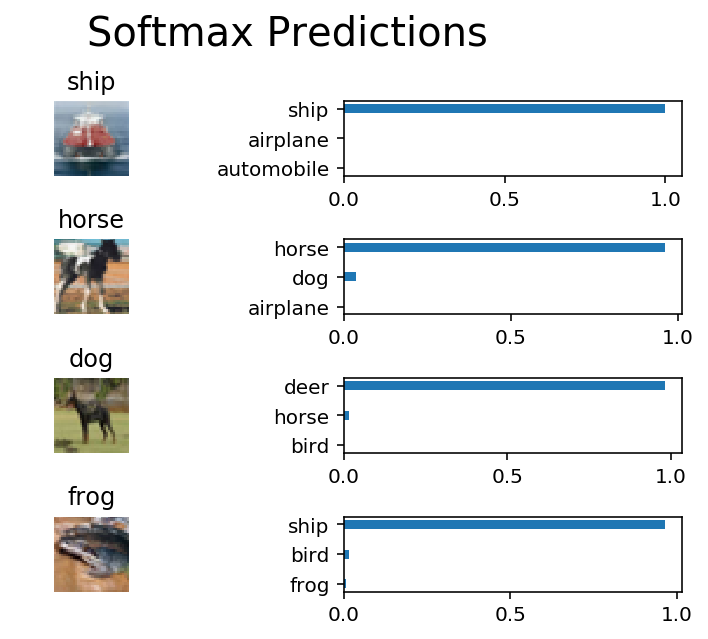

In [33]:
predictionDisplayer = PredictionDisplayer(dataBatchLoader, dataExplorer)

modelTester = ModelTester(dataBatchLoader, predictionDisplayer)

modelTester.test_model(save_model_path, n_samples, n_classes, top_n_predictions)